# PCA con los datos de las compras de supermercados

Vamos a realizar operaciones de **clustering** (segmentación) de datos.
La idea es encontrar una estructura dentro de un dataset donde originalmente no la había.
No se tiene un objetivo de predicción (se trata **aprendizaje no supervisado**), sino de uno de entendimiento de los datos a través del particionamiento del dataset en grupos de instancias.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from collections import Counter


from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn import preprocessing
from sklearn.decomposition import PCA

Cargamos los datos

In [2]:
data = pd.read_csv('09-03-ComprasClientes.csv', na_values=".")
print(data.shape)
data.head(5)

(440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## Limpieza del conjunto de datos

1. Las variables Channel y Region tienen tipo int64, cuando en realidad codifican categorías de canales y de regiones. Es necesario cambiar sus tipos.
1. Tenemos en todas las variables de consumo valores anormalmente grandes que pueden considerarse excepciones en el mejor de los casos (anomalías o errores de captura en el peor de los casos). Hay que identificar los registros en cuestión y evaluar la posibilidad de descartarlos pues pueden influenciar negativamente muchos de los modelos que se pueden aprender a partir de los datos.
1. Las escalas de las variables que denotan los montos consumidos de cada tipo de productos son muy disparejas. Es necesario normalizar los datos ya que de no hacerlo se otorgaría una importancia demasiado desmedida a variables como Fresh casi que ignorando variables como Delicatessen.

Arreglamos primero los tipos de datos incorrectos:

In [3]:
data.Channel = data.Channel.astype(str)
data.Region = data.Region.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel           440 non-null    object
 1   Region            440 non-null    object
 2   Fresh             440 non-null    int64 
 3   Milk              440 non-null    int64 
 4   Grocery           440 non-null    int64 
 5   Frozen            440 non-null    int64 
 6   Detergents_Paper  440 non-null    int64 
 7   Delicassen        440 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 27.6+ KB


Vemos que hay valores muy importantes en todas las variables. Si contamos los puntos individuales más elevados podemos identificar 6 o menos puntos que sobrepasan la mayoría de los demás.
Puede que algunos de los puntos excepcionales en las diferentes variables correspondan a los mismos individuos. Vamos a identificar los top 6 de valores mas importantes en cada tipo de producto y no los vamos a considerar en los análisis siguientes.

In [4]:
temp = data.sort_values(['Fresh'], ascending=False)
print("Excepciones de Fresh: ", np.sort(temp[0:6].index.to_numpy()))
indicesAQuitar = temp[0:6].index.to_numpy()

temp = data.sort_values(['Milk'], ascending=False)
print("Excepciones de Milk: ", np.sort(temp[0:6].index.to_numpy()))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index.to_numpy())

temp = data.sort_values(['Grocery'], ascending=False)
print("Excepciones de Grocery: ", np.sort(temp[0:6].index.to_numpy()))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index.to_numpy())

temp = data.sort_values(['Frozen'], ascending=False)
print("Excepciones de Frozen: ", np.sort(temp[0:6].index.to_numpy()))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index.to_numpy())

temp = data.sort_values(['Detergents_Paper'], ascending=False)
print("Excepciones de Detergents_Paper: ", np.sort(temp[0:6].index.to_numpy()))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index.to_numpy())

temp = data.sort_values(['Delicassen'], ascending=False)
print("Excepciones de Delicassen: ", np.sort(temp[0:6].index.to_numpy()))
indicesAQuitar = np.union1d(indicesAQuitar, temp[0:6].index.to_numpy())

indicesAQuitar

Excepciones de Fresh:  [ 39 103 125 181 258 284]
Excepciones de Milk:  [ 23  47  61  85  86 183]
Excepciones de Grocery:  [ 47  61  65  85 211 333]
Excepciones de Frozen:  [ 93 103 183 196 325 413]
Excepciones de Detergents_Paper:  [ 47  61  65  85  86 333]
Excepciones de Delicassen:  [  2  23  71  87 181 183]


array([  2,  23,  39,  47,  61,  65,  71,  85,  86,  87,  93, 103, 125,
       181, 183, 196, 211, 258, 284, 325, 333, 413], dtype=int64)

Tenemos 22 registros identificados como excepciones. Vemos que algunos tienen valores excepcionales según diferentes tipos de consumo (23, 47, 61, 65, 85, ...)

In [5]:
data.shape

(440, 8)

In [6]:
dataDepurado = data.loc[~data.index.isin(indicesAQuitar)]
dataDepurado.shape

(418, 8)

Vamos ahora a normalizar los datos para que todas las variables tengan la misma importancia. Solo vamos a considerar los datos numéricos, por lo que no incluimos las variables Channel y Region.

In [7]:
dataStd = pd.DataFrame(preprocessing.scale(dataDepurado.iloc[:,2:]))
dataStd.columns=dataDepurado.columns[2:]

In [8]:
dataStd.mean(axis=0)

Fresh               1.540501e-17
Milk               -6.188564e-17
Grocery             3.612209e-17
Frozen             -3.665330e-17
Detergents_Paper    9.774212e-17
Delicassen          4.940227e-17
dtype: float64

In [9]:
dataStd.std(axis=0)

Fresh               1.001198
Milk                1.001198
Grocery             1.001198
Frozen              1.001198
Detergents_Paper    1.001198
Delicassen          1.001198
dtype: float64

#  Reducción de dimensionalidad con PCA

Vamos a buscar una mejor representación de los datos que nos permita conservar la mayor cantidad de información a través de la transformación de las 6 variables originales en componentes principales.

In [10]:
pca = PCA()
pca.fit(dataStd.iloc[:, 0:6])

PCA()

Una vez ajustado el objeto PCA a un dataset, este permite acceder a diferentes aspectos resultantes de la transformación:
- components_: los ejes de los componentes principales en función de las variables originales. Como teníamos 6 variables, vamos a tener 6 PCs, cada uno con las cargas (*loadings*) correspondientes a cada variable original.

In [11]:
pca.components_

array([[-0.17662619,  0.5228338 ,  0.56559339, -0.14203832,  0.55055263,
         0.22862423],
       [ 0.56769933,  0.17469576,  0.01449252,  0.57079691, -0.08413359,
         0.56044738],
       [-0.55360648,  0.06001377,  0.01450733,  0.78884862,  0.05902164,
        -0.25286766],
       [-0.58148941, -0.02840574, -0.22970232, -0.15165733, -0.2613142 ,
         0.71903753],
       [ 0.00539122,  0.8221667 , -0.25741756, -0.09342679, -0.44457039,
        -0.22666638],
       [-0.04337661, -0.12553717,  0.7487701 ,  0.00231556, -0.64838402,
        -0.03598638]])

- explained_variance_: la varianza explicada por cada eje en las unidades originales

In [12]:
pca.explained_variance_

array([2.76398686, 1.37032648, 0.77368869, 0.70151795, 0.29581152,
       0.10905698])

- explained_variance_ratio_: la proporción de la varianza explicada por cada eje, en porcentaje (la suma da 100%).

In [13]:
var_exp=pca.explained_variance_ratio_ # varianza explicada por cada PC
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por los primeros n PCs
var_exp

array([0.45956241, 0.22784136, 0.12863963, 0.11663995, 0.04918397,
       0.01813268])

El objeto PCA sirve además para pasar de la representación en las dimensiones originales a la de las dimensiones en el espacio de los componentes principales encontrados, a partir de su método transform:

In [14]:
dataPca = pca.transform(dataStd.iloc[:, 0:6])

Veamos gráficamente la cantidad de información correspondiente a cada componente principal:

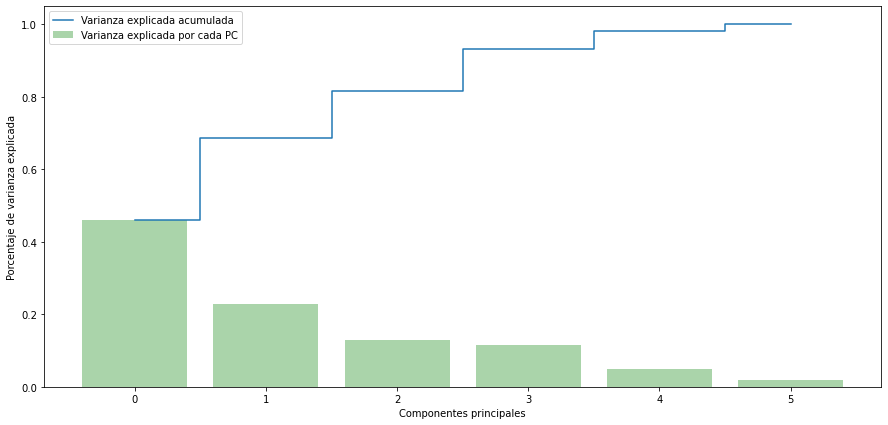

In [15]:
plt.figure(figsize=(15, 7))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3333, align='center', label='Varianza explicada por cada PC', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='Varianza explicada acumulada')
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.show()

In [16]:
np.sum(pca.explained_variance_ratio_[0:3])

0.816043400131198

Encontramos que los primeros 3 componentes conservan el 81.6% de la información original, y los primeros 4 el 93.2%.
Vamos a quedarnos solo con los 3 primeros PCs.

In [17]:
dataPca = dataPca[:,0:3]

In [18]:
dataPca[0:5]

array([[ 0.65616859, -0.14521921, -0.70151548],
       [ 1.04179537,  0.03955682, -0.04681131],
       [-1.08287362,  1.05893268,  0.7024402 ],
       [ 0.41309556,  2.81706414, -1.12899739],
       [ 0.22698998, -0.22216463, -0.45936679]])

Vamos a ver los puntos en el nuevo sistema de representación dado por los componentes principales.
Creamos una función que permite plotear tanto los puntos de los datos como los loadings de las variables originales (tomada de https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot).
Esto nos permitirá entender mejor la relación entre componentes principales y variables originales.

In [19]:
def biplot(data, loadings, index1, index2, labels=None):
    plt.figure(figsize=(15, 7))
    xs = data[:,index1]
    ys = data[:,index2]
    n=loadings.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, loadings[i,index1], loadings[i,index2],color='r',alpha=0.5)
        if labels is None:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(loadings[i,index1]* 1.15, loadings[i,index2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(index1))
    plt.ylabel("PC{}".format(index2))
    plt.grid() 

Veamos como nos va con los primeros dos componentes principales:

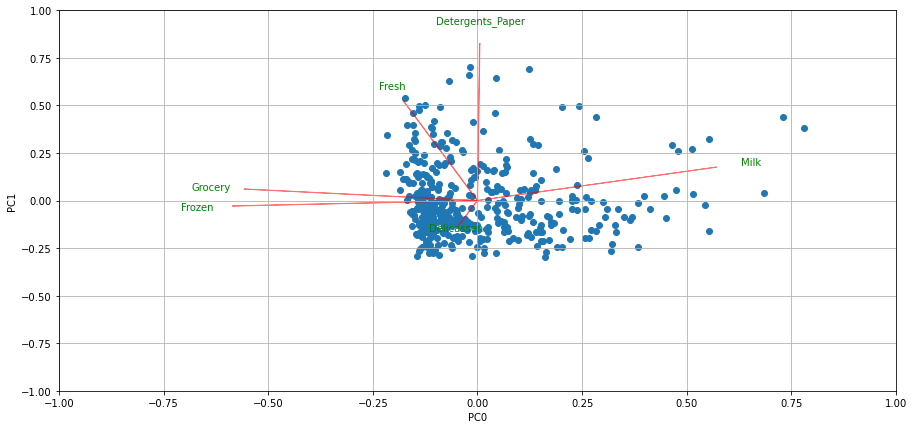

In [20]:
biplot(dataPca, pca.components_, 0, 1, ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'])

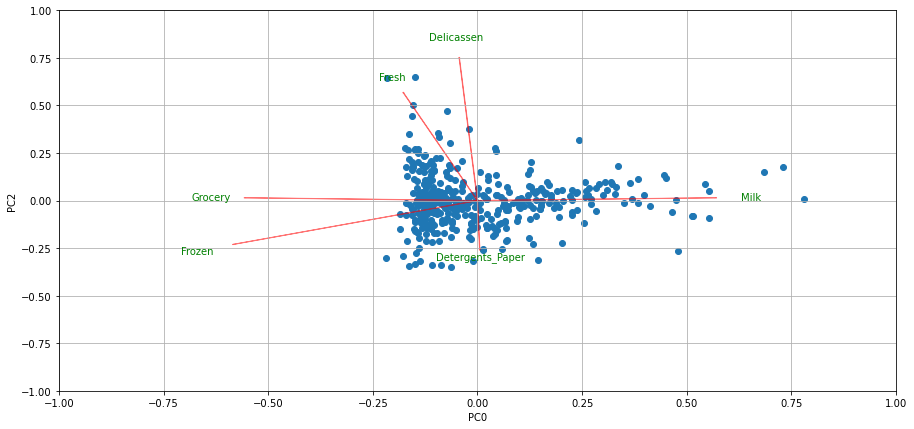

In [21]:
biplot(dataPca, pca.components_, 0, 2, ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'])

In [22]:
dataStd.columns[0:6]

Index(['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'], dtype='object')

In [23]:
pca.components_

array([[-0.17662619,  0.5228338 ,  0.56559339, -0.14203832,  0.55055263,
         0.22862423],
       [ 0.56769933,  0.17469576,  0.01449252,  0.57079691, -0.08413359,
         0.56044738],
       [-0.55360648,  0.06001377,  0.01450733,  0.78884862,  0.05902164,
        -0.25286766],
       [-0.58148941, -0.02840574, -0.22970232, -0.15165733, -0.2613142 ,
         0.71903753],
       [ 0.00539122,  0.8221667 , -0.25741756, -0.09342679, -0.44457039,
        -0.22666638],
       [-0.04337661, -0.12553717,  0.7487701 ,  0.00231556, -0.64838402,
        -0.03598638]])

Podemos decir que:
- El componente PC1 representa positivamente las compras de leche en su sentido positivo, y negativamente las compras en Groceries y Frozen. Las otras variables no tienen mayor incidencia.
- El componente PC2 representa sobretodo las compras de Detergentes/Papel y Fresh (positivamente)
- El componente PC3 representa sobretodo las compras de Delicatessen y Fresh (positivamente), y Detergentes/Papel y Frozen (negativamente)

Ahora que ya entendemos el significado de los componentes principales, podemos proseguir a un clustering de los registros en el espacio reducido:

In [24]:
dataPca = pd.DataFrame(dataPca)
dataPca.columns=['PC1', 'PC2', 'PC3']

In [25]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(dataPca)
clusters = kmeans.labels_

In [26]:
dataPca['Cluster']= clusters
counter=Counter(clusters)
print(counter)

Counter({1: 228, 2: 98, 0: 92})


In [27]:
var_num = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

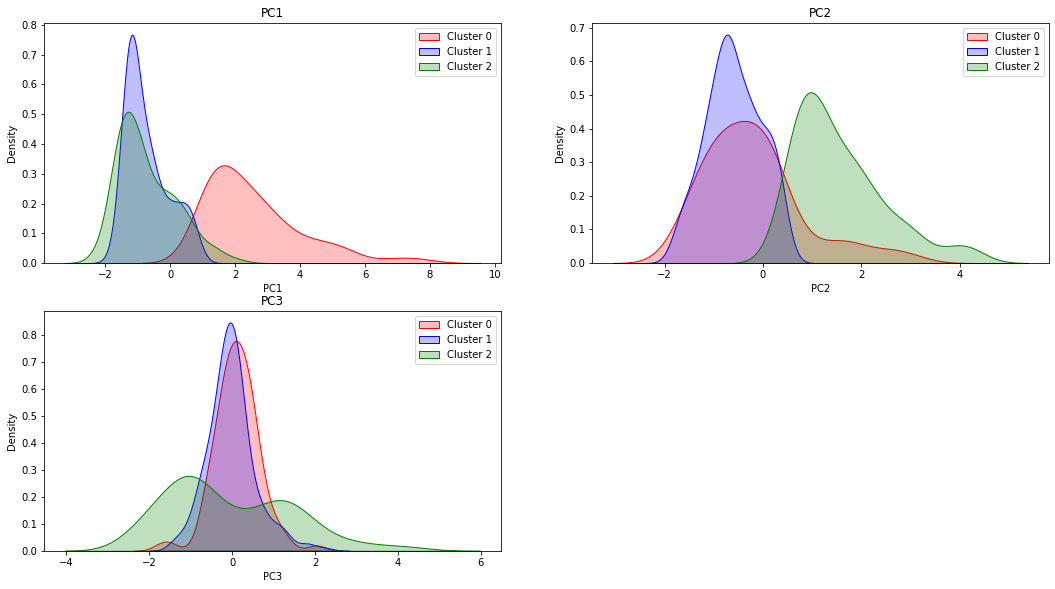

In [28]:
fig = plt.figure(figsize=(18,15))
i=1
for var in dataPca.columns[0:3]:
    ax = fig.add_subplot(math.ceil(len(var_num)/2), 2, i)
    sns.kdeplot(dataPca.loc[dataPca.Cluster==0][var], shade=True, color='r', ax=ax);
    sns.kdeplot(dataPca.loc[dataPca.Cluster==1][var], shade=True, color='b', ax=ax);
    sns.kdeplot(dataPca.loc[dataPca.Cluster==2][var], shade=True, color='g', ax=ax);
    plt.title(var)
    plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    i+=1

Vemos que con K=3, El PC1 sirve para separar bien los puntos del cluster rojo (0), el PC2 sirve para distinguir el cluster verde (2). El cluster azul (1) no se puede separar directamente de los demas a través de uno de los PCs, pero si al considerar los 3 PCs.

Veamoslos en scatterplots para entender mejor las diferencias:

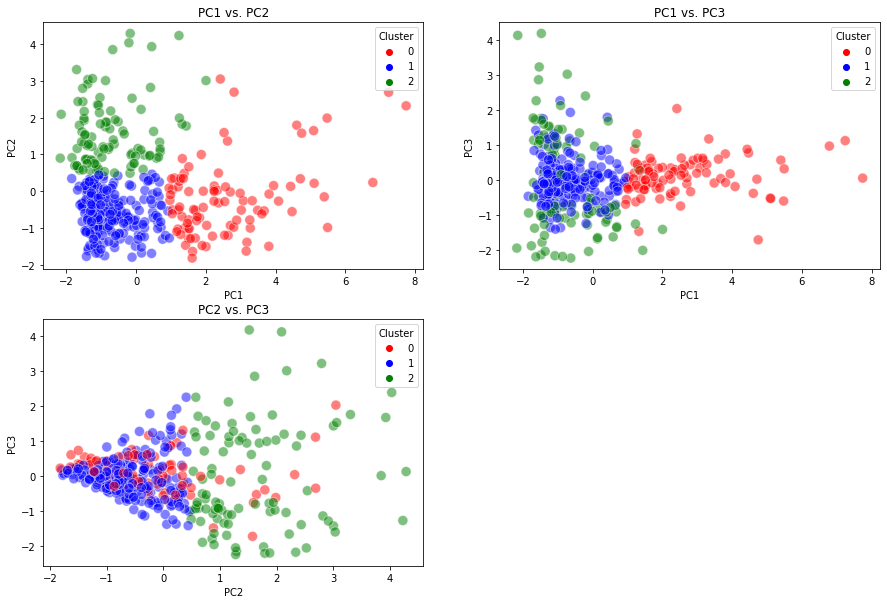

In [29]:
fig = plt.figure(figsize=(15,10))
colorPalette = ["r", "b", "g"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC2")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="PC1", y="PC3", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC1 vs. PC3")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="PC2", y="PC3", hue="Cluster", data=dataPca, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("PC2 vs. PC3")
plt.show()

Vemos que con K=3, en el plot de los 2 primeros PCs podemos separar bien los 3 clusters.
Recordemos que el PC1 representa positivamente las compras de leche en su sentido positivo, y negativamente las compras en Groceries y Frozen, y que el componente PC2 representa sobretodo las compras de Detergentes/Papel y Fresh (positivamente).

**Nota**: Realizar la determinación del número de cluster puede hacerse tanto en el espacio de representación original (ya estandarizado) como en el de los componentes principales (considerandolos todos). Los resultados serán los mismos, ya que tanto el método del codo como el de la silueta se basan en cálculos de distancias, que se conservan después de la transformación en componentes temporales, que no es más que una rotación de los ejes.
